In [1]:
#some code imported from ARIMA lesson by GA instructor Riley Dallas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

from pandas.plotting import register_matplotlib_converters #avoid FutureWarning issue
register_matplotlib_converters()

In [2]:
df = pd.read_csv('exxon_sentiment_clean.csv')

In [3]:
df.head() #preview

,Date,Value,Daily News Sentiment_INT,Daily News Sentiment_NA
0,2017-02-28,81.32,0.0,0.0
1,2017-03-01,83.02,0.0,0.0
2,2017-03-02,83.30,0.0,-0.2
3,2017-03-03,82.46,0.0,0.0
4,2017-03-06,82.83,-0.2,-0.2


In [5]:
df.set_index(pd.to_datetime(df['Date']), inplace=True) #set index to be the date column as a datetime index

In [6]:
df.drop(columns='Date', inplace=True)

In [7]:
df.head() #confirm

,Value,Daily News Sentiment_INT,Daily News Sentiment_NA
Date,,,
2017-02-28,81.32,0.0,0.0
2017-03-01,83.02,0.0,0.0
2017-03-02,83.30,0.0,-0.2
2017-03-03,82.46,0.0,0.0
2017-03-06,82.83,-0.2,-0.2


In [8]:
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps= 0):
    plt.figure(figsize=(18,9))
    for col in cols:
        plt.plot(df[col])
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);
    

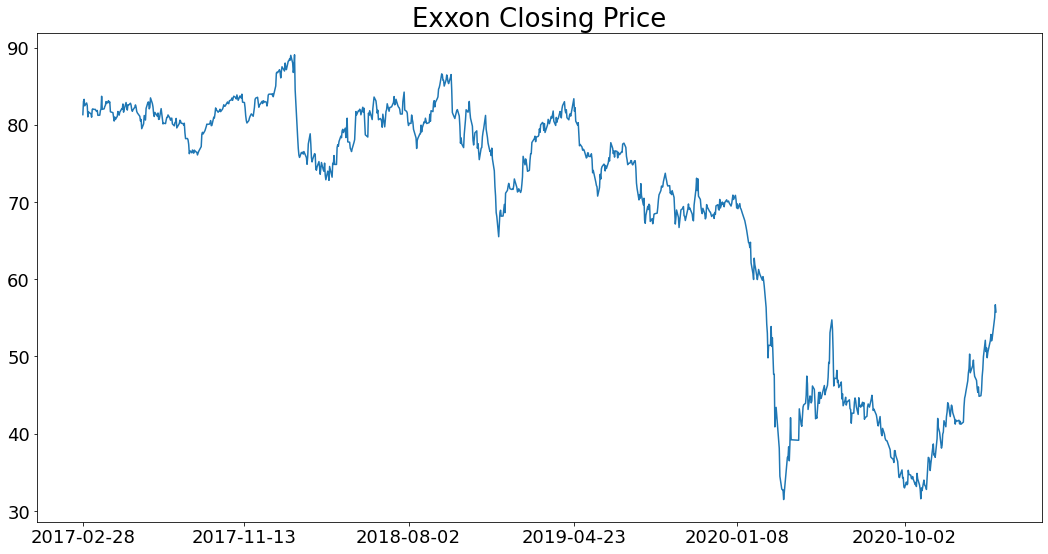

In [15]:
plot_series(df, cols=['Value'], title='Exxon Closing Price', 
           steps=180)

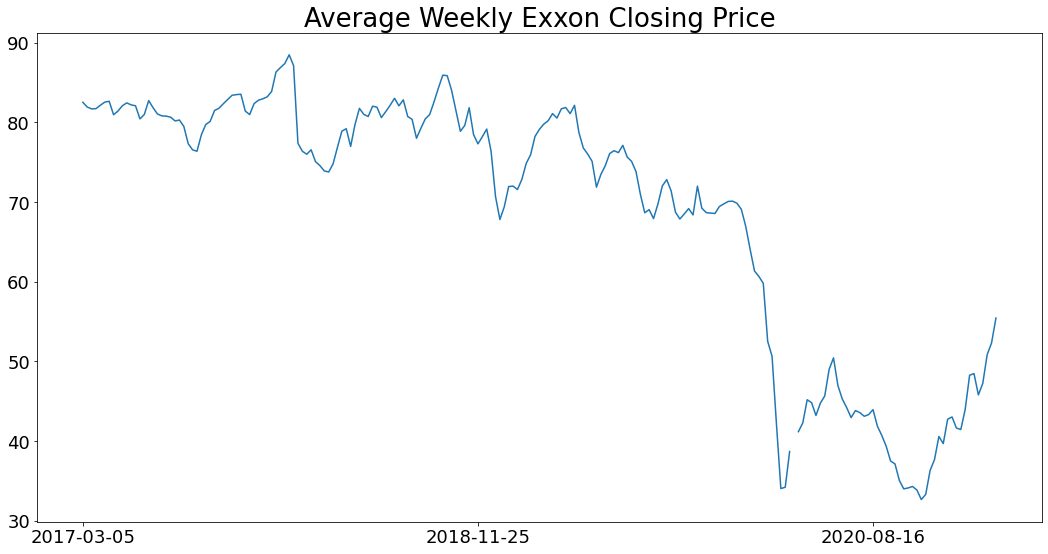

In [16]:
plot_series(df.resample('W').mean(),
           cols=['Value'],
           title='Average Weekly Exxon Closing Price',
           steps=90)

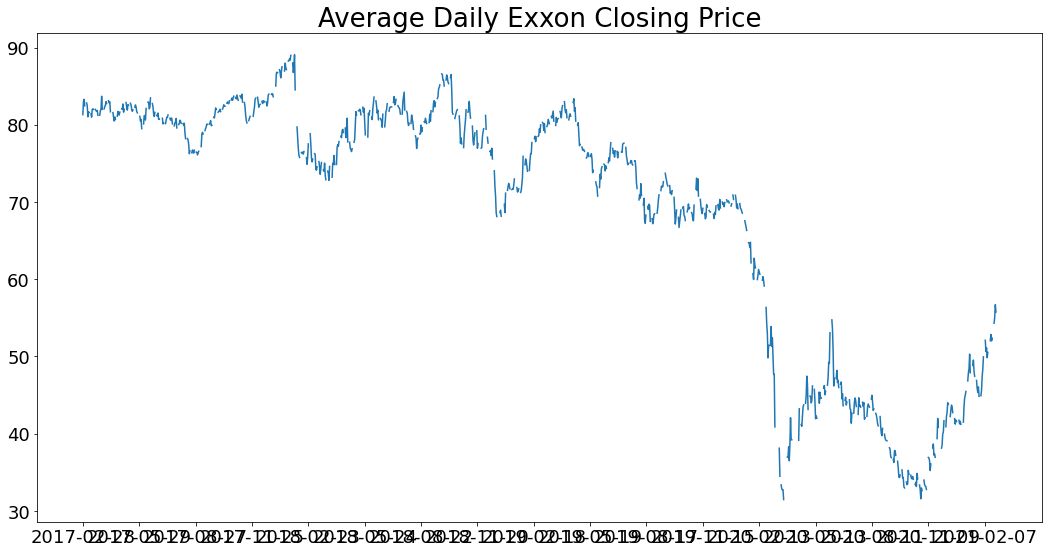

In [18]:
plot_series(df.resample('D').mean(),
           cols=['Value'],
           title='Average Daily Exxon Closing Price',
           steps=90)

In [19]:
dfw = df.resample('W').mean() #new df resampled on weekly average

In [21]:
dfw.head() #preview

,Value,Daily News Sentiment_INT,Daily News Sentiment_NA
Date,,,
2017-03-05,82.525,0.000,-0.050
2017-03-12,81.932,-0.254,-0.040
2017-03-19,81.696,-0.160,-0.076
2017-03-26,81.736,-0.150,-0.020
2017-04-02,82.164,-0.080,-0.040


In [22]:
dfw.isnull().sum() #1 null value to impute...

Value                       1
Daily News Sentiment_INT    1
Daily News Sentiment_NA     1
dtype: int64

In [29]:
dfw[dfw['Value'].isnull()]

,Value,Daily News Sentiment_INT,Daily News Sentiment_NA
Date,,,
2020-04-12,NaN,NaN,NaN


In [30]:
dfw.dropna(inplace=True)

In [33]:
#irst 5 values, differenced once
dfw.diff()

,Value,Daily News Sentiment_INT,Daily News Sentiment_NA
Date,,,
2017-03-05,NaN,NaN,NaN
2017-03-12,-0.5930,-0.2540,0.0100
2017-03-19,-0.2360,0.0940,-0.0360
2017-03-26,0.0400,0.0100,0.0560
2017-04-02,0.4280,0.0700,-0.0200
...,...,...,...
2021-01-31,-2.6735,-0.2235,0.0400
2021-02-07,1.4460,0.0620,-0.1320
2021-02-14,3.5920,0.0400,0.1220


In [34]:
#need to test to verify that data are stationary
dfw['first_diff'] = dfw['Value'].diff()
dfw['second_diff'] = dfw['Value'].diff().diff()

In [35]:
dfw.head() #preview

,Value,Daily News Sentiment_INT,Daily News Sentiment_NA,first_diff,second_diff
Date,,,,,
2017-03-05,82.525,0.000,-0.050,NaN,NaN
2017-03-12,81.932,-0.254,-0.040,-0.593,NaN
2017-03-19,81.696,-0.160,-0.076,-0.236,0.357
2017-03-26,81.736,-0.150,-0.020,0.040,0.276
2017-04-02,82.164,-0.080,-0.040,0.428,0.388


In [36]:
#Stationarity = variability centers aroudn a mean

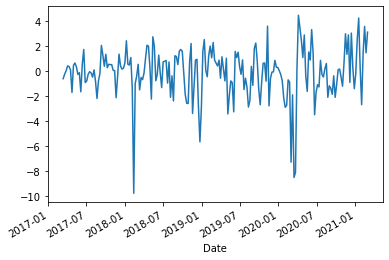

In [37]:
dfw['first_diff'].plot() #variability doesn't seem consistent here...

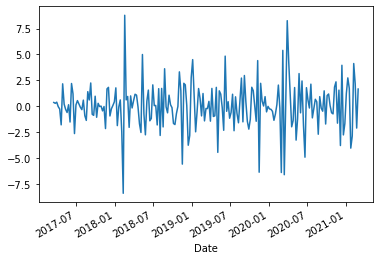

In [38]:
dfw['second_diff'].plot() #looks more centered around the horizontal mean

In [39]:
#if p value is less than alpha, reject null hypothesis (not stationary) and concluded that it is stationary; else, fail to reject null hypothesis, data are not stationary
#looking for p value less than .01
from statsmodels.tsa.stattools import adfuller

#run on original series
adfuller(dfw['Value'])

(-1.2907836009643747,
 0.6333782084047053,
 1,
 206,
 {'1%': -3.4624988216864776,
  '5%': -2.8756749365852587,
  '10%': -2.5743041549627677},
 795.037367613965)

In [42]:
#code by Joseph Nelson and Hovanes Gasperian (GA)
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])
    return dfoutput

In [43]:
interpret_dftest(adfuller(dfw['Value'])) #auto picks lags

Test Statistic   -1.290784
p-value           0.633378
Lags Used         1.000000
dtype: float64

In [44]:
#with an alpha of .01, p-value is larger therefore we fail to reject the null hypothesis

In [45]:
interpret_dftest(adfuller(dfw['first_diff'].dropna())) #skip first row (differenced, is NaN)

Test Statistic   -9.785365e+00
p-value           6.565407e-17
Lags Used         0.000000e+00
dtype: float64

In [ ]:
#we can reject null hypothesis and conclude the data are stationary after a single .diff() !

In [52]:
y_train, y_test = train_test_split(dfw['Value'], test_size = .1, #90% training data
                                  shuffle=False) #no need for random seed because no shuffling occurs

In [53]:
from statsmodels.tsa.arima_model import ARIMA

In [55]:
#starting values
best_aic = 99*(10**16)
best_p = 0
best_q = 0

for p in range(5): #manual grid search via nested for-loop
    for q in range(5):
        try:
            print(f'Fitting an ARIMA({p}, 1, {q}) model.')
            arima = ARIMA(endog=y_train, order=(p,1,q))
            
            model = arima.fit()
            
            print(f'The AIC for ARIMA({p}, 1, {q}) is: {model.aic}')
            
            if model.aic < best_aic:
                best_aic = model.aic
                best_p = p
                best_q = q
        except:
            pass

Fitting an ARIMA(0, 1, 0) model.
The AIC for ARIMA(0, 1, 0) is: 778.6367993804733
Fitting an ARIMA(0, 1, 1) model.
The AIC for ARIMA(0, 1, 1) is: 755.4058458705255
Fitting an ARIMA(0, 1, 2) model.
The AIC for ARIMA(0, 1, 2) is: 756.9268117686968
Fitting an ARIMA(0, 1, 3) model.
The AIC for ARIMA(0, 1, 3) is: 758.9262859926375
Fitting an ARIMA(0, 1, 4) model.


C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no ass

The AIC for ARIMA(0, 1, 4) is: 760.7321281216027
Fitting an ARIMA(1, 1, 0) model.
The AIC for ARIMA(1, 1, 0) is: 756.4215426478394
Fitting an ARIMA(1, 1, 1) model.
The AIC for ARIMA(1, 1, 1) is: 756.9308244257461
Fitting an ARIMA(1, 1, 2) model.


C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no ass

The AIC for ARIMA(1, 1, 2) is: 758.768398777195
Fitting an ARIMA(1, 1, 3) model.
The AIC for ARIMA(1, 1, 3) is: 760.7654626857658
Fitting an ARIMA(1, 1, 4) model.
Fitting an ARIMA(2, 1, 0) model.

C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no ass


The AIC for ARIMA(2, 1, 0) is: 757.024647254236
Fitting an ARIMA(2, 1, 1) model.
The AIC for ARIMA(2, 1, 1) is: 758.9297326292842
Fitting an ARIMA(2, 1, 2) model.


C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no ass

The AIC for ARIMA(2, 1, 2) is: 759.2966164803861
Fitting an ARIMA(2, 1, 3) model.


C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


The AIC for ARIMA(2, 1, 3) is: 754.6218692987584
Fitting an ARIMA(2, 1, 4) model.
Fitting an ARIMA(3, 1, 0) model.
The AIC for ARIMA(3, 1, 0) is: 758.9465668508776
Fitting an ARIMA(3, 1, 1) model.
The AIC for ARIMA(3, 1, 1) is: 760.9262884612901
Fitting an ARIMA(3, 1, 2) model.


C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no ass

The AIC for ARIMA(3, 1, 2) is: 756.1684712077781
Fitting an ARIMA(3, 1, 3) model.
The AIC for ARIMA(3, 1, 3) is: 756.2982755121168
Fitting an ARIMA(3, 1, 4) model.


C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasti

The AIC for ARIMA(3, 1, 4) is: 762.2122709339326
Fitting an ARIMA(4, 1, 0) model.
The AIC for ARIMA(4, 1, 0) is: 760.8014451330268
Fitting an ARIMA(4, 1, 1) model.
The AIC for ARIMA(4, 1, 1) is: 760.5844009892517
Fitting an ARIMA(4, 1, 2) model.


C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


The AIC for ARIMA(4, 1, 2) is: 760.1075430020429
Fitting an ARIMA(4, 1, 3) model.


C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:672: RuntimeWarning: invalid value encountered in arctanh
  invarcoefs = 2*np.arctanh(params)
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarni

Fitting an ARIMA(4, 1, 4) model.


C:\Users\willg\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):
C:\Users\willg\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):
C:\Users\willg\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1


In [56]:
#ARIMA 2,1,3 has an AIC of 754 which looks to be the smallest - that should be our best model

In [58]:
y_test.index[0]

Timestamp('2020-10-11 00:00:00')

In [59]:
y_test.index[-1]

Timestamp('2021-02-28 00:00:00')

In [60]:
model = ARIMA(endog=y_train,
             order=(2,1,3))
arima = model.fit()

preds = model.predict(params=arima.params,
                     start=y_test.index[0],
                     end=y_test.index[-1])

plt.figure(figsize=(10,6))
plt.plot(y_train.index, pd.DataFrame(y_train).diff(), color='blue') #plot train
plt.plot(y_test.index, pd.DataFrame(y_test).diff(), color='orange') #plot test
plt.plot(y_test.index, preds, color='green')
plt.title(label='Once differenced mean weekly closing price')
plt.show();

C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\willg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


KeyError: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'